# Snohomish Property Sales Data Prediction

- **Objective: Explore Snohomish county residential property sales data and predict selling price using house features.**<br>

- **Dataset: Downloaded from Washington Snohomish County Assessors [FTP Portal](ftp://ftp.snoco.org/assessor/property_sales)**
    - Dataset: Last 5 years of property sales in the Snohomish County, WA ([AllSales_2021_10_06.xlsx](ftp://ftp.snoco.org/assessor/property_sales/Snohomish%20County%20Sales/AllSales_2021_10_06.xlsx))
    - Data Dictionary: [Field Names](ftp://ftp.snoco.org/assessor/property_sales/Snohomish%20County%20Sales/Res%20Sales%20Report%20FieldNames.docx) and [Property_Class_Codes](ftp://ftp.snoco.org/assessor/property_sales/Snohomish%20County%20Sales/Property_Class_Codes_2015-10-27.pdf)

- **Author: [Mangesh Jadhav](https://www.linkedin.com/in/mangeshjadhav/)**

## 1) Install and Import Utilities

In [1]:
# Install utilities
!python3 -m pip install -qU pip
!python3 -m pip install -qU setuptools wheel
!python3 -m pip install -qU "mxnet<2.0.0"
!python3 -m pip install -qU autogluon
!python3 -m pip install -qU pandasql

In [2]:
# Import utilities
import pandas as pd
import numpy as np
from pandasql import sqldf 
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.tabular import TabularPredictor, TabularDataset

## 2) Import & Explore Dataset

In [3]:
df_raw = TabularDataset(data="./Datasets/Dataset_Snohomish_AllSales.csv")
print(df_raw.shape) # raw dataset has 104,113 rows and 51 columns

pd.options.display.max_columns = None
df_raw.head()

(104113, 51)


,LRSN,Parcel_Id,Status,SD_Nbr,Nbhd,TRSQ,Prop_Class,Sale_Date,Sale_Price,Excise_Nbr,Deed_Type,Sale_Qual_Code,V/I,LL1_Type,LL1_Calc_Method,LL1_Acres,Ll1_SqFt,Ll1_FF,Ll1_EFF,Total_Land_Size,zoning,Ll1_Inf_1,Last_Value_Update,Imp_Value,Mkt_Land_Value,Total_Market_Value,Land_Use_Value,Change_Reason,eff_year,Exten,Imp_Type,Impr_Width,Imp_Length,Grade,Grade_Desc,Yr_Blt,Eff_Yr_Blt,House_Type,Hse_Type_Desc,Bedrooms,MH_Length,MH_Width,Imp_Size,B_L_SqFt,1st_SqFt,Upper_SqFt,Total_SqFt,PCT_Comp,mkt_rdf,Transfer_Update_Date,Cert_Value_Ratio
0,1200918,795300003900,A,2,1101008,2804011,111,06-15-18,"415,000",E105532,W,Q,VVVV,A3,7.0,0.15,"6,534",0,0,0.16,EVE R-2,NaN,05-18-21,"262,600","244,000","506,600",0.0,1.0,20210101.0,R01,DWELL,0.0,0.0,45.0,Avg,1994.0,1994.0,11.0,1 Sty,3.0,0.0,0.0,0,0,"1,578",0,"1,578",100.0,100.0,08-12-20,1.2207
1,1200918,795300003900,A,2,1101008,2804011,111,05-18-20,"499,950",E138761,W,Q,VVVV,A3,7.0,0.15,"6,534",0,0,0.16,EVE R-2,NaN,05-18-21,"262,600","244,000","506,600",0.0,1.0,20210101.0,R01,DWELL,0.0,0.0,45.0,Avg,1994.0,1994.0,11.0,1 Sty,3.0,0.0,0.0,0,0,"1,578",0,"1,578",100.0,100.0,08-12-20,1.0133
2,1200919,795300004000,A,2,1101008,2804011,111,08-24-16,"366,000",E074105,W,Q,VVVV,A3,7.0,0.15,"6,534",0,0,0.18,EVE R-2,NaN,05-18-21,"271,800","244,000","515,800",0.0,1.0,20210101.0,R01,DWELL,0.0,0.0,45.0,Avg,1994.0,1994.0,17.0,2 Sty,4.0,0.0,0.0,0,0,"1,083","1,028","2,111",100.0,100.0,09-09-21,1.4093
3,1200927,795300004800,A,2,1101008,2804011,111,01-25-19,"480,000",E115591,W,Q,VVVV,A3,7.0,0.15,"6,534",0,0,0.17,EVE R-2,NaN,05-18-21,"295,800","244,000","539,800",0.0,1.0,20210101.0,R01,DWELL,0.0,0.0,45.0,Avg,1993.0,1993.0,23.0,Split Entry,3.0,0.0,0.0,0,624,"1,372",0,"1,996",100.0,100.0,03-16-20,1.1246
4,1200927,795300004800,A,2,1101008,2804011,111,07-25-18,"375,000",E108006,W,Q,VVVV,A3,7.0,0.15,"6,534",0,0,0.17,EVE R-2,NaN,05-18-21,"295,800","244,000","539,800",0.0,1.0,20210101.0,R01,DWELL,0.0,0.0,45.0,Avg,1993.0,1993.0,23.0,Split Entry,3.0,0.0,0.0,0,624,"1,372",0,"1,996",100.0,100.0,03-16-20,1.4395


## 3) Data Processing & Exploration



### 3.1) Limiting Columns & Formatting Data Types

In [4]:
# Subset potentially useful columns:
df_subset = df_raw[['Parcel_Id', 'SD_Nbr', 'Prop_Class', 'Sale_Qual_Code', 'Sale_Date', 'Sale_Price', 'Ll1_SqFt', 'Total_SqFt', 'Grade', 'Grade_Desc', 'Yr_Blt', 'House_Type', 'Hse_Type_Desc', 'Bedrooms']]

df_subset.info()

pd.options.mode.chained_assignment = None  # default='warn'
# Remove comma's from the numerical columns and cast as float
df_subset['Sale_Price'] = df_subset['Sale_Price'].str.replace(',', '').astype(float)
df_subset['Ll1_SqFt'] = df_subset['Ll1_SqFt'].str.replace(',', '').astype(float)
df_subset['Total_SqFt'] = df_subset['Total_SqFt'].str.replace(',', '').astype(float)

# It seems the Ll1_SqFt > Total_SqFt; Hence renaming columns to easily understandable notations
df_subset.rename(columns={"Ll1_SqFt": "Land_SqFt", "Total_SqFt": "Built_SqFt"}, inplace=True)

df_subset.head()

<class 'autogluon.core.dataset.TabularDataset'>
RangeIndex: 104113 entries, 0 to 104112
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Parcel_Id       104113 non-null  int64  
 1   SD_Nbr          104113 non-null  int64  
 2   Prop_Class      104113 non-null  int64  
 3   Sale_Qual_Code  104113 non-null  object 
 4   Sale_Date       104113 non-null  object 
 5   Sale_Price      104113 non-null  object 
 6   Ll1_SqFt        100483 non-null  object 
 7   Total_SqFt      92100 non-null   object 
 8   Grade           97248 non-null   float64
 9   Grade_Desc      97247 non-null   object 
 10  Yr_Blt          97248 non-null   float64
 11  House_Type      97248 non-null   float64
 12  Hse_Type_Desc   97237 non-null   object 
 13  Bedrooms        97248 non-null   float64
dtypes: float64(4), int64(3), object(7)
memory usage: 11.1+ MB


,Parcel_Id,SD_Nbr,Prop_Class,Sale_Qual_Code,Sale_Date,Sale_Price,Land_SqFt,Built_SqFt,Grade,Grade_Desc,Yr_Blt,House_Type,Hse_Type_Desc,Bedrooms
0,795300003900,2,111,Q,06-15-18,415000.0,6534.0,1578.0,45.0,Avg,1994.0,11.0,1 Sty,3.0
1,795300003900,2,111,Q,05-18-20,499950.0,6534.0,1578.0,45.0,Avg,1994.0,11.0,1 Sty,3.0
2,795300004000,2,111,Q,08-24-16,366000.0,6534.0,2111.0,45.0,Avg,1994.0,17.0,2 Sty,4.0
3,795300004800,2,111,Q,01-25-19,480000.0,6534.0,1996.0,45.0,Avg,1993.0,23.0,Split Entry,3.0
4,795300004800,2,111,Q,07-25-18,375000.0,6534.0,1996.0,45.0,Avg,1993.0,23.0,Split Entry,3.0


### 3.2) Exploring Target Variable `Sale_Price`

In [5]:
# Check summary stats for Sale_Price
df_subset['Sale_Price'].describe()

# There seem to be many outliers in the Sale_Price
    # Min: $1
    # Max: 200 Million Dollars

count    1.041130e+05
mean     9.319880e+05
std      3.961962e+06
min      1.000000e+00
25%      3.300000e+05
50%      4.589900e+05
75%      6.359170e+05
max      2.000000e+08
Name: Sale_Price, dtype: float64

### 3.3) Removing NULLS and 0's from `Land_SqFt` and `House_SqFt`

In [6]:
df_subset.isnull().sum()

# Removing rows where House_SqFt and/or Land_SqFt have NULLS; NOT trying to impute missing values
df_subset = df_subset.dropna(subset = ['Land_SqFt', 'Built_SqFt'])

# Removing rows where Land_SqFt = 0
df_subset = df_subset[df_subset['Land_SqFt'] != 0]
df_subset = df_subset[df_subset['Built_SqFt'] != 0]

### 3.4) Limiting Data for Property Type = `Single Family Residence – Detached (One Structure)`

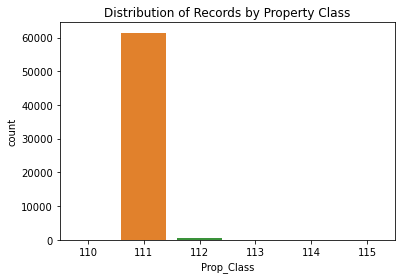

In [7]:
# This huge variation might be due to different Property Types (Single Family vs Condo vs Land)
# For this exercise, let's focus on Single Family Residences
    # As per data dictionary, Single Family Residences (Household, Single Family Units) have Prop_Class from 110 to 115

prop_class_single_fam_res = [110, 111, 112, 113, 114, 115]
df_subset = df_subset[df_subset['Prop_Class'].isin(prop_class_single_fam_res)]

# Most of the records are for Prop_Class 111 i.e. Single Family Residence – Detached (One Structure)
sns.countplot(x = 'Prop_Class', data = df_subset);
plt.title('Distribution of Records by Property Class')
plt.savefig('./Results/1_Property_Class_Distribution.jpg')
plt.show()

# Filtering the dataset further to look into Single Family Residence – Detached (One Structure)
df_subset = df_subset[df_subset['Prop_Class'] == 111]

### 3.5) Limiting Data for Sales Qualification Code = `Qualified`

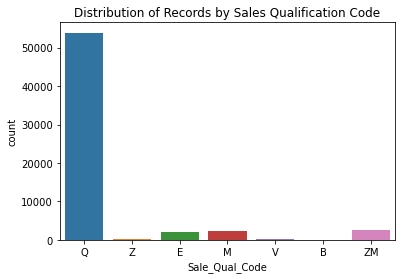

In [8]:
# Most of the records are for Sale_Qual_Code Q i.e. Qualified Sales
sns.countplot(x = 'Sale_Qual_Code', data = df_subset);
plt.title('Distribution of Records by Sales Qualification Code')
plt.savefig('./Results/2_Sales_Qualification_Code_Distribution.jpg')
plt.show()

# Filtering the dataset further to look into Qualified Sales
df_subset = df_subset[df_subset['Sale_Qual_Code'] == 'Q']

### 3.6) Data Processing & Exploration: `Sale_Date`

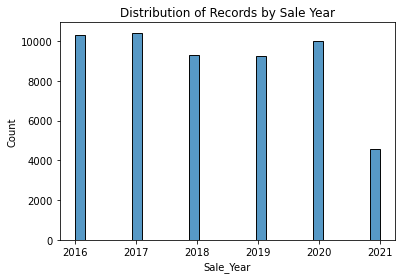

In [9]:
pd.options.mode.chained_assignment = None  # default='warn'

df_subset['Sale_Date'] = pd.DatetimeIndex(df_subset['Sale_Date']).date
df_subset['Sale_Year'] = pd.DatetimeIndex(df_subset['Sale_Date']).year
df_subset['Sale_Month'] = pd.DatetimeIndex(df_subset['Sale_Date']).month

# The sales data is complete for years 2016-2020 and partial for year 2021
sns.histplot(x = 'Sale_Year', data = df_subset);
plt.title('Distribution of Records by Sale Year')
plt.savefig('./Results/3_Sale_Year_Distribution.jpg')
plt.show()

### 3.7) Removing Duplicates for `Parcel_ID`

In [10]:
print("Count of Records:", df_subset.Parcel_Id.count())
print("Count of Unique Values in Parcel_ID:", df_subset.Parcel_Id.nunique())

df_subset[df_subset['Parcel_Id'] == 795300003900] # sample record with duplicate Parcel_Id

Count of Records: 53872
Count of Unique Values in Parcel_ID: 47073


,Parcel_Id,SD_Nbr,Prop_Class,Sale_Qual_Code,Sale_Date,Sale_Price,Land_SqFt,Built_SqFt,Grade,Grade_Desc,Yr_Blt,House_Type,Hse_Type_Desc,Bedrooms,Sale_Year,Sale_Month
0,795300003900,2,111,Q,2018-06-15,415000.0,6534.0,1578.0,45.0,Avg,1994.0,11.0,1 Sty,3.0,2018,6
1,795300003900,2,111,Q,2020-05-18,499950.0,6534.0,1578.0,45.0,Avg,1994.0,11.0,1 Sty,3.0,2020,5


In [11]:
# Assign Rank = 1 for recent record of Sale for Parcel ID
query_txt = '''
SELECT
     ROW_NUMBER() over (PARTITION BY Parcel_Id ORDER BY Sale_Date DESC) as Rank_Recent_Parcel_Id
    ,*
FROM df_subset
'''

df_subset = sqldf(query_txt)

# Keep only recent sell records in the dataset
df_subset = df_subset[df_subset['Rank_Recent_Parcel_Id'] == 1]

# Drop the intermediate column
df_subset.drop(['Rank_Recent_Parcel_Id'], axis=1, inplace=True)

print("Count of Records:", df_subset.Parcel_Id.count())
print("Count of Unique Values in Parcel_ID:", df_subset.Parcel_Id.nunique())

Count of Records: 47073
Count of Unique Values in Parcel_ID: 47073


### 3.8) Data Processing & Exploration: `Price_Per_Built_SqFt`

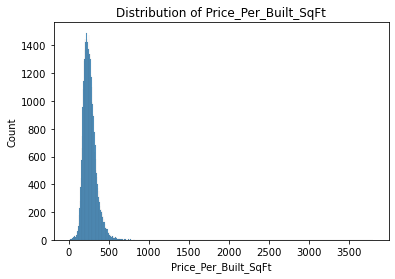

In [12]:
df_subset['Price_Per_Built_SqFt'] = df_subset['Sale_Price'] / df_subset['Built_SqFt']

sns.histplot(x = 'Price_Per_Built_SqFt', data = df_subset);
plt.title('Distribution of Price_Per_Built_SqFt')
plt.show()

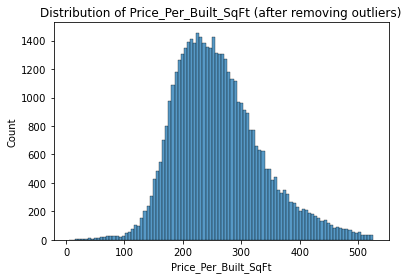

In [13]:
Price_Per_Built_SqFt_Upper_Bound = df_subset['Price_Per_Built_SqFt'].mean() + (3*df_subset['Price_Per_Built_SqFt'].std())
Price_Per_Built_SqFt_Lower_Bound = max(df_subset['Price_Per_Built_SqFt'].mean() - (3*df_subset['Price_Per_Built_SqFt'].std()) , 0)

# Filtering the dataset further avoid outliers for Price_Per_Built_SqFt
df_subset = df_subset[df_subset['Price_Per_Built_SqFt'] < Price_Per_Built_SqFt_Upper_Bound]
df_subset = df_subset[df_subset['Price_Per_Built_SqFt'] > Price_Per_Built_SqFt_Lower_Bound]
                       
sns.histplot(x = 'Price_Per_Built_SqFt', data = df_subset);
plt.title('Distribution of Price_Per_Built_SqFt (after removing outliers)')
plt.savefig('./Results/5_Price_Per_Built_SqFt_Distribution.jpg')
plt.show()

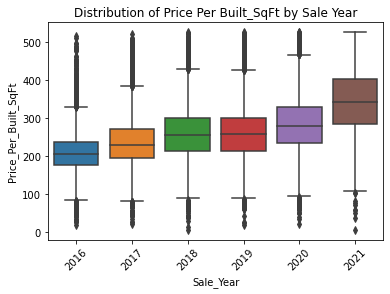

In [14]:
sns.boxplot(x='Sale_Year', y='Price_Per_Built_SqFt', data = df_subset)
plt.title('Distribution of Price Per Built_SqFt by Sale Year')
plt.xticks(rotation=45)
plt.savefig('./Results/4_Price_Per_Built_SqFt_Distribution_By_Sale_Year.jpg')
plt.show()

### 3.9) Data Processing & Exploration: `Built_To_Land_Ratio`

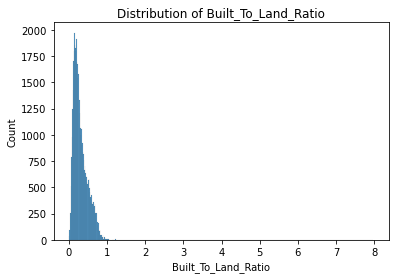

In [15]:
df_subset['Built_To_Land_Ratio'] = df_subset['Built_SqFt'] / df_subset['Land_SqFt']

sns.histplot(x = 'Built_To_Land_Ratio', data = df_subset);
plt.title('Distribution of Built_To_Land_Ratio')
plt.show()

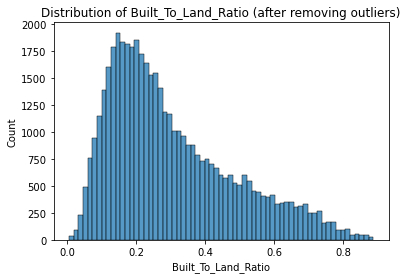

In [16]:
Built_To_Land_Ratio_Upper_Bound = df_subset['Built_To_Land_Ratio'].mean() + (3*df_subset['Built_To_Land_Ratio'].std())
Built_To_Land_Ratio_Lower_Bound = max(df_subset['Built_To_Land_Ratio'].mean() - (3*df_subset['Built_To_Land_Ratio'].std()) , 0)

# Filtering the dataset further avoid outliers for Built_To_Land_Ratio
df_subset = df_subset[df_subset['Built_To_Land_Ratio'] < Built_To_Land_Ratio_Upper_Bound]
df_subset = df_subset[df_subset['Built_To_Land_Ratio'] > Built_To_Land_Ratio_Lower_Bound]
                       
sns.histplot(x = 'Built_To_Land_Ratio', data = df_subset);
plt.title('Distribution of Built_To_Land_Ratio (after removing outliers)')
plt.savefig('./Results/6_Built_To_Land_Ratio_Distribution.jpg')
plt.show()

### 3.10) Data Processing & Exploration: `Grade`

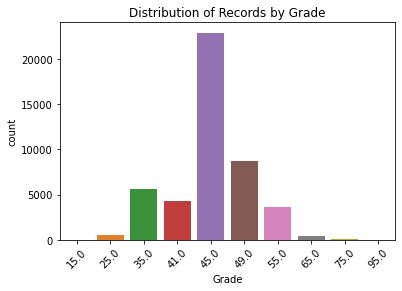

In [17]:
sns.countplot(x = 'Grade', data = df_subset);
plt.title('Distribution of Records by Grade')
plt.xticks(rotation=45)
plt.savefig('./Results/7_Grade_Distribution.jpg')
plt.show()

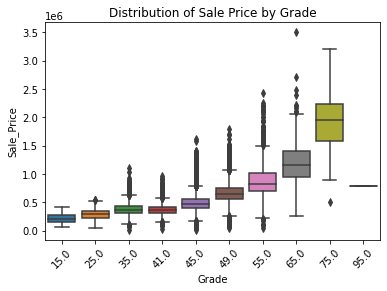

In [18]:
sns.boxplot(x='Grade', y='Sale_Price', data = df_subset)
plt.title('Distribution of Sale Price by Grade')
plt.xticks(rotation=45)
plt.savefig('./Results/8_Sale_Price_Distribution_By_Grade.jpg')
plt.show()

### 3.11) Data Processing & Exploration: `House_Type`

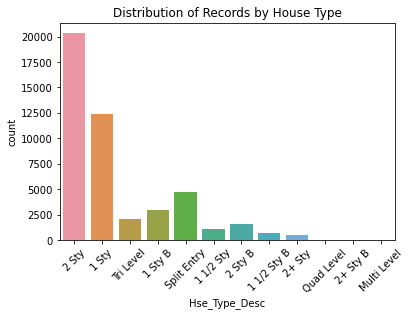

In [19]:
sns.countplot(x = 'Hse_Type_Desc', data = df_subset);
plt.title('Distribution of Records by House Type')
plt.xticks(rotation=45)
plt.savefig('./Results/9_House_Type_Distribution.jpg')
plt.show()

# Filtering the dataset further avoid outliers for House_Type
Exclude_House_Type_Desc = ['Quad Level', '2+ Sty B', 'Multi Level']
df_subset = df_subset[~df_subset['Hse_Type_Desc'].isin(Exclude_House_Type_Desc)]

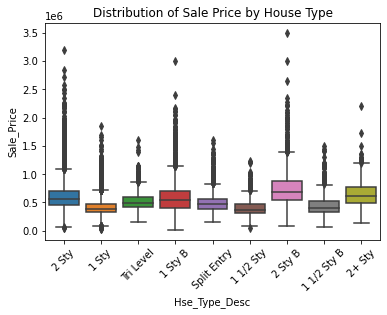

In [20]:
sns.boxplot(x='Hse_Type_Desc', y='Sale_Price', data = df_subset)
plt.title('Distribution of Sale Price by House Type')
plt.xticks(rotation=45)
plt.savefig('./Results/10_Sale_Price_Distribution_By_House_Type.jpg')
plt.show()

### 3.12) Data Processing & Exploration: `SD_Nbr`

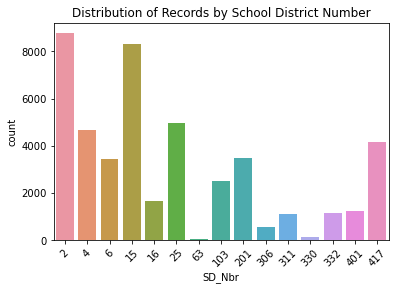

In [21]:
sns.countplot(x = 'SD_Nbr', data = df_subset);
plt.title('Distribution of Records by School District Number')
plt.xticks(rotation=45)
plt.savefig('./Results/11_School_District_Distribution.jpg')
plt.show()

# Filtering the dataset further avoid outliers for School District
Exclude_SD_Nbr = [63, 330, 306]
df_subset = df_subset[~df_subset['SD_Nbr'].isin(Exclude_SD_Nbr)]

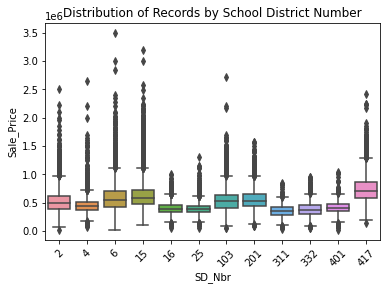

In [22]:
sns.boxplot(x='SD_Nbr', y='Sale_Price', data = df_subset)
plt.title('Distribution of Records by School District Number')
plt.xticks(rotation=45)
plt.savefig('./Results/12_Sale_Price_Distribution_By_School_District.jpg')
plt.show()

### 3.13) Data Processing & Exploration: `Bedrooms`

   Bedrooms  Cnt_Records
0       1.0          219
1       2.0         2460
2       3.0        21595
3       4.0        16315
4       5.0         4548


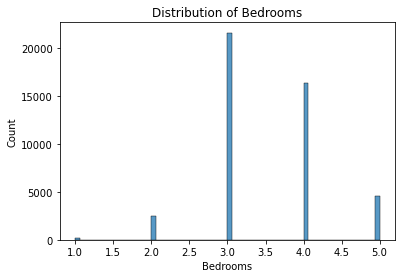

In [23]:
# Filtering the dataset further avoid outliers for Bedrooms
df_subset = df_subset[df_subset['Bedrooms'] > 0] # Single Family Houses should have atleast 1 Bedroom
df_subset = df_subset[df_subset['Bedrooms'] < 6] # Exclude Single Family Houses with 6+ Bedroom

query_txt = '''
SELECT
     Bedrooms
    ,COUNT(Parcel_Id) as Cnt_Records
FROM df_subset
GROUP BY
     Bedrooms
ORDER BY
     Bedrooms ASC
'''

print(sqldf(query_txt))

sns.histplot(x = 'Bedrooms', data = df_subset);
plt.title('Distribution of Bedrooms')
plt.savefig('./Results/13_Bedrooms_Distribution.jpg')
plt.show()

### 3.14) Explpring Target Variable: `Sale_Price`

In [24]:
df_subset['Sale_Price'].describe()

count    4.513700e+04
mean     5.367846e+05
std      2.248003e+05
min      1.000000e+04
25%      3.899500e+05
50%      4.895000e+05
75%      6.300000e+05
max      3.500000e+06
Name: Sale_Price, dtype: float64

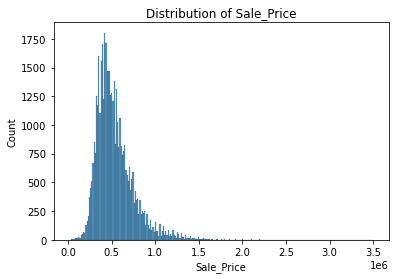

In [25]:
sns.histplot(x = 'Sale_Price', data = df_subset);
plt.title('Distribution of Sale_Price')
plt.savefig('./Results/14_Sale_Price_Distribution.jpg')
plt.show()

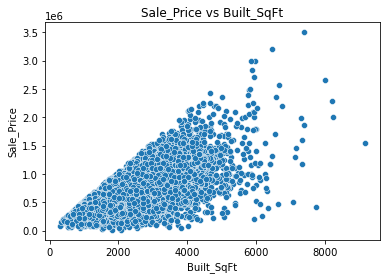

In [26]:
sns.scatterplot(y = 'Sale_Price', x = 'Built_SqFt', data = df_subset);
plt.title('Sale_Price vs Built_SqFt')
plt.savefig('./Results/15_Sale_Price_vs_Built_SqFt_Scatter.jpg')
plt.show()

### 3.15) Building Processed, Training & Testing Datasets

In [27]:
# Take log of Sale_Price to treat RMSE of low and high Sale_Price equally
pd.options.mode.chained_assignment = None  # default='warn'
df_subset['Sale_Price_Log_Base10'] = np.log10(df_subset['Sale_Price'])

# Identify list of test Parcel_Id to be used for prediction testing
list_test_Parcel_Id = df_subset[((df_subset['Sale_Year'] == 2021) & (df_subset['Sale_Month'] >= 5))]['Parcel_Id'].to_list()

# Create a clean dataframe of processed variables
df_processed = df_subset[['Parcel_Id','Sale_Price_Log_Base10','Built_SqFt','Land_SqFt','Yr_Blt','Bedrooms','Grade','House_Type','SD_Nbr','Sale_Year']]

# Create training & testing datasets (test predictions on May 2021 onwards sale prices)
df_test = df_processed[df_processed['Parcel_Id'].isin(list_test_Parcel_Id)]
df_train = df_processed[~(df_processed['Parcel_Id'].isin(list_test_Parcel_Id))]

df_test.drop(['Sale_Price_Log_Base10'], axis=1, inplace = True)

print("Shape of df_processed", df_processed.shape)
print("Shape of df_train", df_train.shape)
print("Shape of df_test", df_test.shape)

Shape of df_processed (45137, 10)
Shape of df_train (43640, 10)
Shape of df_test (1497, 9)


## 4) Correlation Matrix

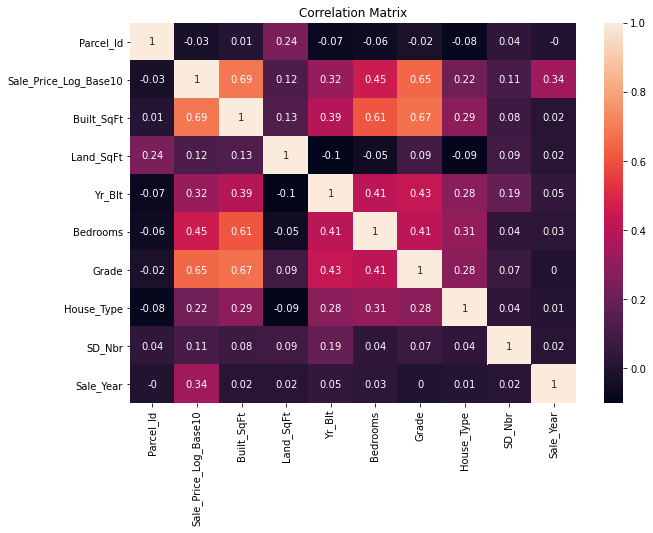

In [28]:
# Check correlation matrix

correlation_matrix = df_train.corr().round(2)
plt.subplots(figsize=(10,7))
sns.heatmap(data=correlation_matrix, annot=True)
plt.title('Correlation Matrix')
plt.savefig('./Results/16_Correlation_Matrix.jpg')
plt.show()


## 5) Model Training

In [ ]:
house_price_predictor = TabularPredictor(label= "Sale_Price_Log_Base10", eval_metric= 'mean_squared_error').fit(
    train_data= df_train, time_limit= 180)

No path specified. Models will be saved in: "AutogluonModels/ag-20211207_040418/"
Beginning AutoGluon training ... Time limit = 180s
AutoGluon will save models to "AutogluonModels/ag-20211207_040418/"
AutoGluon Version:  0.3.1
Train Data Rows:    43640
Train Data Columns: 9
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (6.505149978319906, 4.0, 5.69008, 0.16017)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1950.32 MB
	Train Data (Original)  Memory Usage: 3.14 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_meta

[1000]	train_set's l2: 0.00369892	valid_set's l2: 0.00421531
[2000]	train_set's l2: 0.00320715	valid_set's l2: 0.00410191
[3000]	train_set's l2: 0.00291102	valid_set's l2: 0.00408124


	-0.0041	 = Validation score   (mean_squared_error)
	7.8s	 = Training   runtime
	0.4s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 170.84s of the 170.83s of remaining time.
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 0.0022697	valid_set's l2: 0.00381382


	-0.0038	 = Validation score   (mean_squared_error)
	2.94s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 167.61s of the 167.61s of remaining time.
	-0.0045	 = Validation score   (mean_squared_error)
	8.19s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 158.32s of the 158.31s of remaining time.
	-0.004	 = Validation score   (mean_squared_error)
	3.33s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ... Training model for up to 154.98s of the 154.98s of remaining time.
	-0.0047	 = Validation score   (mean_squared_error)
	2.87s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: NeuralNetFastAI ... Training model for up to 150.85s of the 150.85s of remaining time.
	-0.0056	 = Validation score   (mean_squared_error)
	47.76s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: XGBoost ... Training model for up to 10

In [ ]:
house_price_predictor.leaderboard(silent=True)

In [ ]:
house_price_predictor.get_model_best()

In [ ]:
# Make predictions on the test dataset with the AutoGluon model
predictions = house_price_predictor.predict(df_test)

In [ ]:
# Store prediction results by ID in dataframe and calculate antilog
df_prediction_results = df_test[["Parcel_Id"]].copy(deep=True)
df_prediction_results["Predicted_Sale_Price_Log_Base10"] = predictions
df_prediction_results["Predicted_Sale_Price"] = (10.0 ** df_prediction_results["Predicted_Sale_Price_Log_Base10"]).astype(float)

In [ ]:
# Join actual and predicted results

query_txt = '''
SELECT
      df_prediction_results.*
     ,df_processed.Sale_Price_Log_Base10 AS Actual_Sale_Price_Log_Base10
FROM df_prediction_results
LEFT JOIN df_processed
    ON df_prediction_results.Parcel_Id = df_processed.Parcel_Id
'''

df_prediction_results_comparison = sqldf(query_txt)
df_prediction_results_comparison["Actual_Sale_Price"] = (10.0 ** df_prediction_results_comparison["Actual_Sale_Price_Log_Base10"]).astype(float)


df_prediction_results_comparison["Pct_Error_Sale_Price_Log_Base10"] = ((
    df_prediction_results_comparison["Actual_Sale_Price_Log_Base10"] 
    - df_prediction_results_comparison["Predicted_Sale_Price_Log_Base10"]) 
    / df_prediction_results_comparison["Actual_Sale_Price_Log_Base10"])

df_prediction_results_comparison["Pct_Error_Sale_Price"] = ((
    df_prediction_results_comparison["Actual_Sale_Price"] 
    - df_prediction_results_comparison["Predicted_Sale_Price"]) 
    / df_prediction_results_comparison["Actual_Sale_Price"])


RMSE_Sale_Price_Log_Base10 = np.sqrt((
    (df_prediction_results_comparison["Predicted_Sale_Price_Log_Base10"] 
    - df_prediction_results_comparison["Actual_Sale_Price_Log_Base10"]) ** 2).mean())

RMSE_Sale_Price = np.sqrt((
    (df_prediction_results_comparison["Predicted_Sale_Price"] 
    - df_prediction_results_comparison["Actual_Sale_Price"]) ** 2).mean())


print("RMSE for Logarithms of Predicted and Actual Sales Price: ", RMSE_Sale_Price_Log_Base10)
print("RMSE for Predicted and Actual Sales Price: ", RMSE_Sale_Price)

In [ ]:
# Saving the dataframe as a csv file
df_prediction_results_comparison.to_csv("./Results/prediction_results_comparison.csv",index=False,)

## 6) Interpretability: Feature importance

In [ ]:
# recreate df_test so that it includes target label
df_test = df_processed[df_processed['Parcel_Id'].isin(list_test_Parcel_Id)]

house_price_predictor.feature_importance(df_test)

## 7) Cleanup

In [ ]:
# Clean up Model folder
!rm -r AutogluonModels
!rm -r agModels-predictOccupation

In [ ]:
# Export the files for easier download
!tar chvfz notebook.tar.gz *